## **Load Root Google Drive File dan Import Library**

In [ ]:
## Load Folder Drive
import os, sys
from google.colab import drive
drive.mount('/content/drive/')

## Move Pointer File ke DATA_UM
%cd /content/drive/MyDrive/DATA_UM

## Declare Root Project File
root_file = "/content/drive/MyDrive/DATA_UM"

Mounted at /content/drive/
/content/drive/MyDrive/DATA_UM


In [ ]:
## Install necessary libraries
# &> /dev/null = Remove output Install
!pip install transformers &> /dev/null

# Import necessary libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import re
import string

import os.path
from os import path

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Load Data and Transforming as Required**

####**Load Data for Training, Testing, and Validating**

In [ ]:
## Declare Hashtag Data
hashtag = "ultramilk_initialize"

In [ ]:
## Load Data Training
df = pd.read_csv('data/training/'+hashtag+'/'+hashtag+'.csv')
df.shape

(14955, 16)

In [ ]:
df['id_tweet'] = df.index

####**Labelling Rules (Polarity) :**

##### 0 = Negative,
##### 1 = Neutral,
##### 2 = Positive to Product,
##### 3 = Positive to Others, and
##### 4 = Not Related (other topic / other language).

In [ ]:
## Declare DF For Graph Penyebaran Class
df_class_polarity = pd.DataFrame(
    {
        'class': ['Negative\n(0)', 'Neutral\n(1)', 'Positive to Product\n(2)', 'Positive to Others\n(3)', 'Not Related\n(4)'],
        'id_class' : [0, 1, 2, 3, 4],
        'total': [df[df.labelling == 0].shape[0], df[df.labelling == 1].shape[0], df[df.labelling == 2].shape[0], df[df.labelling == 3].shape[0], df[df.labelling == 4].shape[0]]
        }
    )

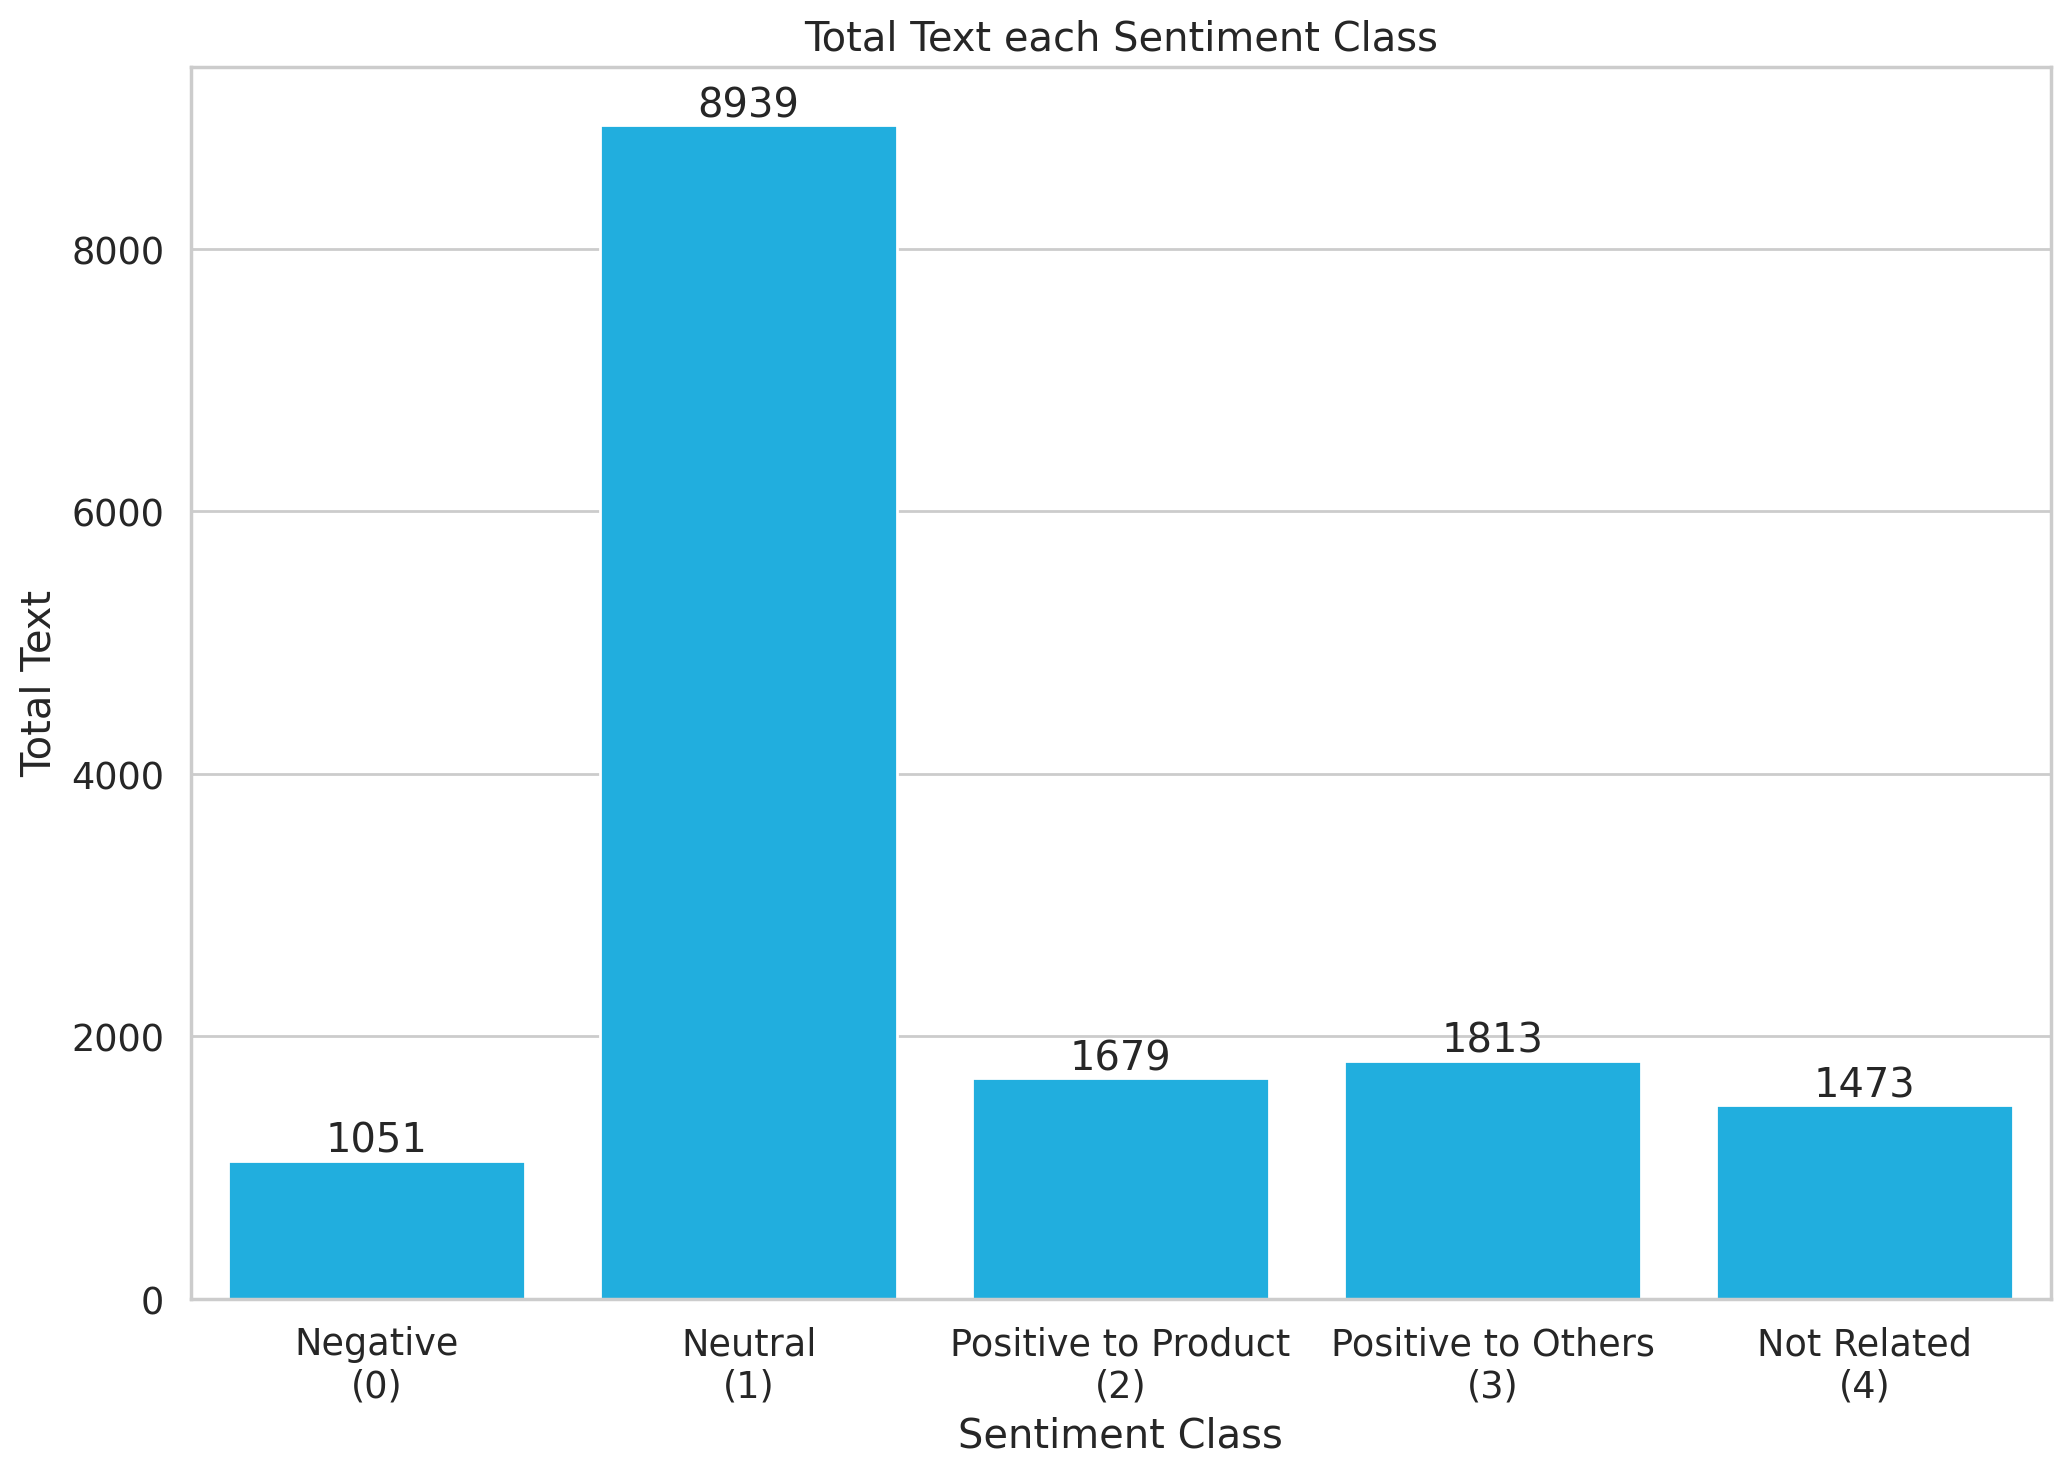

In [ ]:
## Draw Graph Penyebaran Class Polaritas / Labelling
ax = sns.barplot(data=df_class_polarity, x='class', y='total');
ax.set(xlabel='Sentiment Class',
       ylabel='Total Text',
       title='Total Text each Sentiment Class')
ax.bar_label(container=ax.containers[0], labels=df_class_polarity.total)

# Save Image
plt.savefig('report/'+hashtag+'/total_penyebaran_kelas_labelling.png')

####**Labelling Rules (Data Training) :**

##### 0 = Negative,
##### 1 = Neutral,
##### 2 = Positive - (Product, BA and others)

In [ ]:
## LDuplicate Dataframe
df_data = df
df_data_asli = df

## Remove unused Column in DF for Training
df_data = df_data.drop(columns=['date', 'platform',	'brand', 'hashtag', 'name', 'username', 'profile_id', 'comments', 'share_retweet', 'bookmark', 'quotes', 'likes'])

## Adding Collumn Sentiment for Training Model
df_data['labelled'] = 0
df_data_asli['labelled'] = 0

In [ ]:
# Function to convert score to sentiment
def to_sentiment(rating):
    rating = int(rating)
    # Convert to class
    if rating == 0:
      return 0
    elif rating == 1:
      return 1
    elif rating == 2 or rating == 3:
      return 2

# Apply to the dataset
df_data['labelled'] = df_data.labelling.apply(to_sentiment)
df_data_asli['labelled'] = df_data_asli.labelling.apply(to_sentiment)

In [ ]:
# Delete Rows that has value 4 in Polarity (4 tidak dipakai)
df_data = df_data[df.labelling != 4]
df_data['labelled']

68       1.0
78       1.0
79       1.0
86       2.0
106      2.0
        ... 
14950    0.0
14951    0.0
14952    0.0
14953    0.0
14954    0.0
Name: labelled, Length: 13482, dtype: float64

In [ ]:
df_data

,link,text,labelling,text_final,id_tweet,labelled
68,https://twitter.com/RJ_COCOSA/status/154521498...,ULTRA Milk × ITZY #DontStopYourMove,1,ultra milk itzy dontstopyourmove,68,1.0
78,https://twitter.com/LCRuniverse/status/1574284...,ITZY x Ultra Milk promotional ads 😍😍 #ITZY #있...,1,itzy ultra milk promotional ads itzy dontstopy...,78,1.0
79,https://twitter.com/amazinglymad/status/156890...,Hasil dari kunjungan Experience Room Ultra Mil...,1,hasil kunjung experience room ultra milk itzy ...,79,1.0
86,https://twitter.com/kimel_put/status/156894658...,Chaeryeong you’re soooo pretty😍❤️ @ITZYofficia...,3,chaeryeong you re pretty itzyofficial ultramym...,86,2.0
106,https://twitter.com/iniariani/status/171811302...,woy ini seriusan ultra collab sama stray kids?...,3,serius ultra collab sama stray kids gila bang...,106,2.0
...,...,...,...,...,...,...
14950,https://www.instagram.com/p/CZYc-oOh3Xv/,@melikris_ ultramilk saya isinya oli bekas kak...,0,melikris ultramilk isi oli bekas kak tutup seg...,14950,0.0
14951,https://www.instagram.com/p/CZYc-oOh3Xv/,"Cek dm min,!! ultramilk saya ada sesuatu yg me...",0,cek dm admin ultramilk menjijikanpengen muntah...,14951,0.0
14952,https://www.instagram.com/p/CZYc-oOh3Xv/,min ini gimana masa saya beli teh pucuk exp ma...,0,admin bagaimana masa beli teh pucuk exp lama k...,14952,0.0
14953,https://www.instagram.com/p/CZYc-oOh3Xv/,"saya di bohongi tmpt nasi padang, katanya sepa...",0,bohong tempat nasi padang kata paket kirim sa...,14953,0.0


In [ ]:
df_data_neg = df_data[df_data.labelled == 0]
df_data_net = df_data[df_data.labelled == 1]
df_data_pos = df_data[df_data.labelled == 2]

print(df_data_neg.shape, df_data_net.shape, df_data_pos.shape)

df_neg = df_data_neg
df_net = df_data_net.sample(n=3492)
df_pos = df_data_pos

print(df_neg.shape, df_net.shape, df_pos.shape)

(1051, 6) (8939, 6) (3492, 6)
(1051, 6) (3492, 6) (3492, 6)


In [ ]:
df_data = pd.concat([df_neg, df_net, df_pos], ignore_index=True)
df_data

,link,text,labelling,text_final,id_tweet,labelled
0,https://twitter.com/handoghouse/status/1576844...,"Ekspektasi q ketinggian 😭 Tebel, bagus, tp kok...",0,ekspektasi tinggi tebal bagus kok finishingnya...,699,0.0
1,https://twitter.com/VaLone1605/status/15793490...,Habis buka card agak nyesek gara gara bagian k...,0,habis buka card sesak gara gara kiri cacad ter...,1582,0.0
2,https://twitter.com/TheMidz_/status/1576914035...,Ini siapa bangsat kek bukan Ryujin sumpah #Don...,0,siapa bangsat bukan ryujin sumpah dontstopyou...,1594,0.0
3,https://twitter.com/AlvnLiu/status/15769093112...,Baru buka udah damage😭 bisa komplain ga sih😭ke...,0,baru buka damage komplain tidak sih kecewaa ul...,1595,0.0
4,https://twitter.com/AlvnLiu/status/15769093112...,Baru buka udah damage😭 bisa komplain ga sih😭ke...,0,baru buka damage komplain tidak sih kecewaa ul...,1664,0.0
...,...,...,...,...,...,...
8030,https://www.instagram.com/p/Cy5zndgPv-d/,@kei.khaira ayo kita beli susu yg banyakkkkk,2,keikhaira ayo beli susu banyak,14020,2.0
8031,https://www.instagram.com/p/Cy5zndgPv-d/,"CAKEP"" BEUTTT",3,cakep banget,14024,2.0
8032,https://www.instagram.com/p/CzFsyLArKoe,kesyukaanku,2,kesyukaanku,14036,2.0
8033,https://www.instagram.com/p/CzFsyLArKoe,Ultra dr kecil mmg susu favorit..❤️❤️❤️,2,ultra kecil memang susu favorit,14039,2.0


In [ ]:
## Declare DF For Graph Penyebaran Class
df_class_sentimen = pd.DataFrame(
    {
        'class': ['Negative\n(0)', 'Neutral\n(1)', 'Positive\n(2)'],
        'id_class' : [0, 1, 2],
        'total': [df_data[df_data.labelled == 0].shape[0], df_data[df_data.labelled == 1].shape[0], df_data[df_data.labelled == 2].shape[0]]
        }
    )
df_class_sentimen

,class,id_class,total
0,Negative\n(0),0,1051
1,Neutral\n(1),1,3492
2,Positive\n(2),2,3492


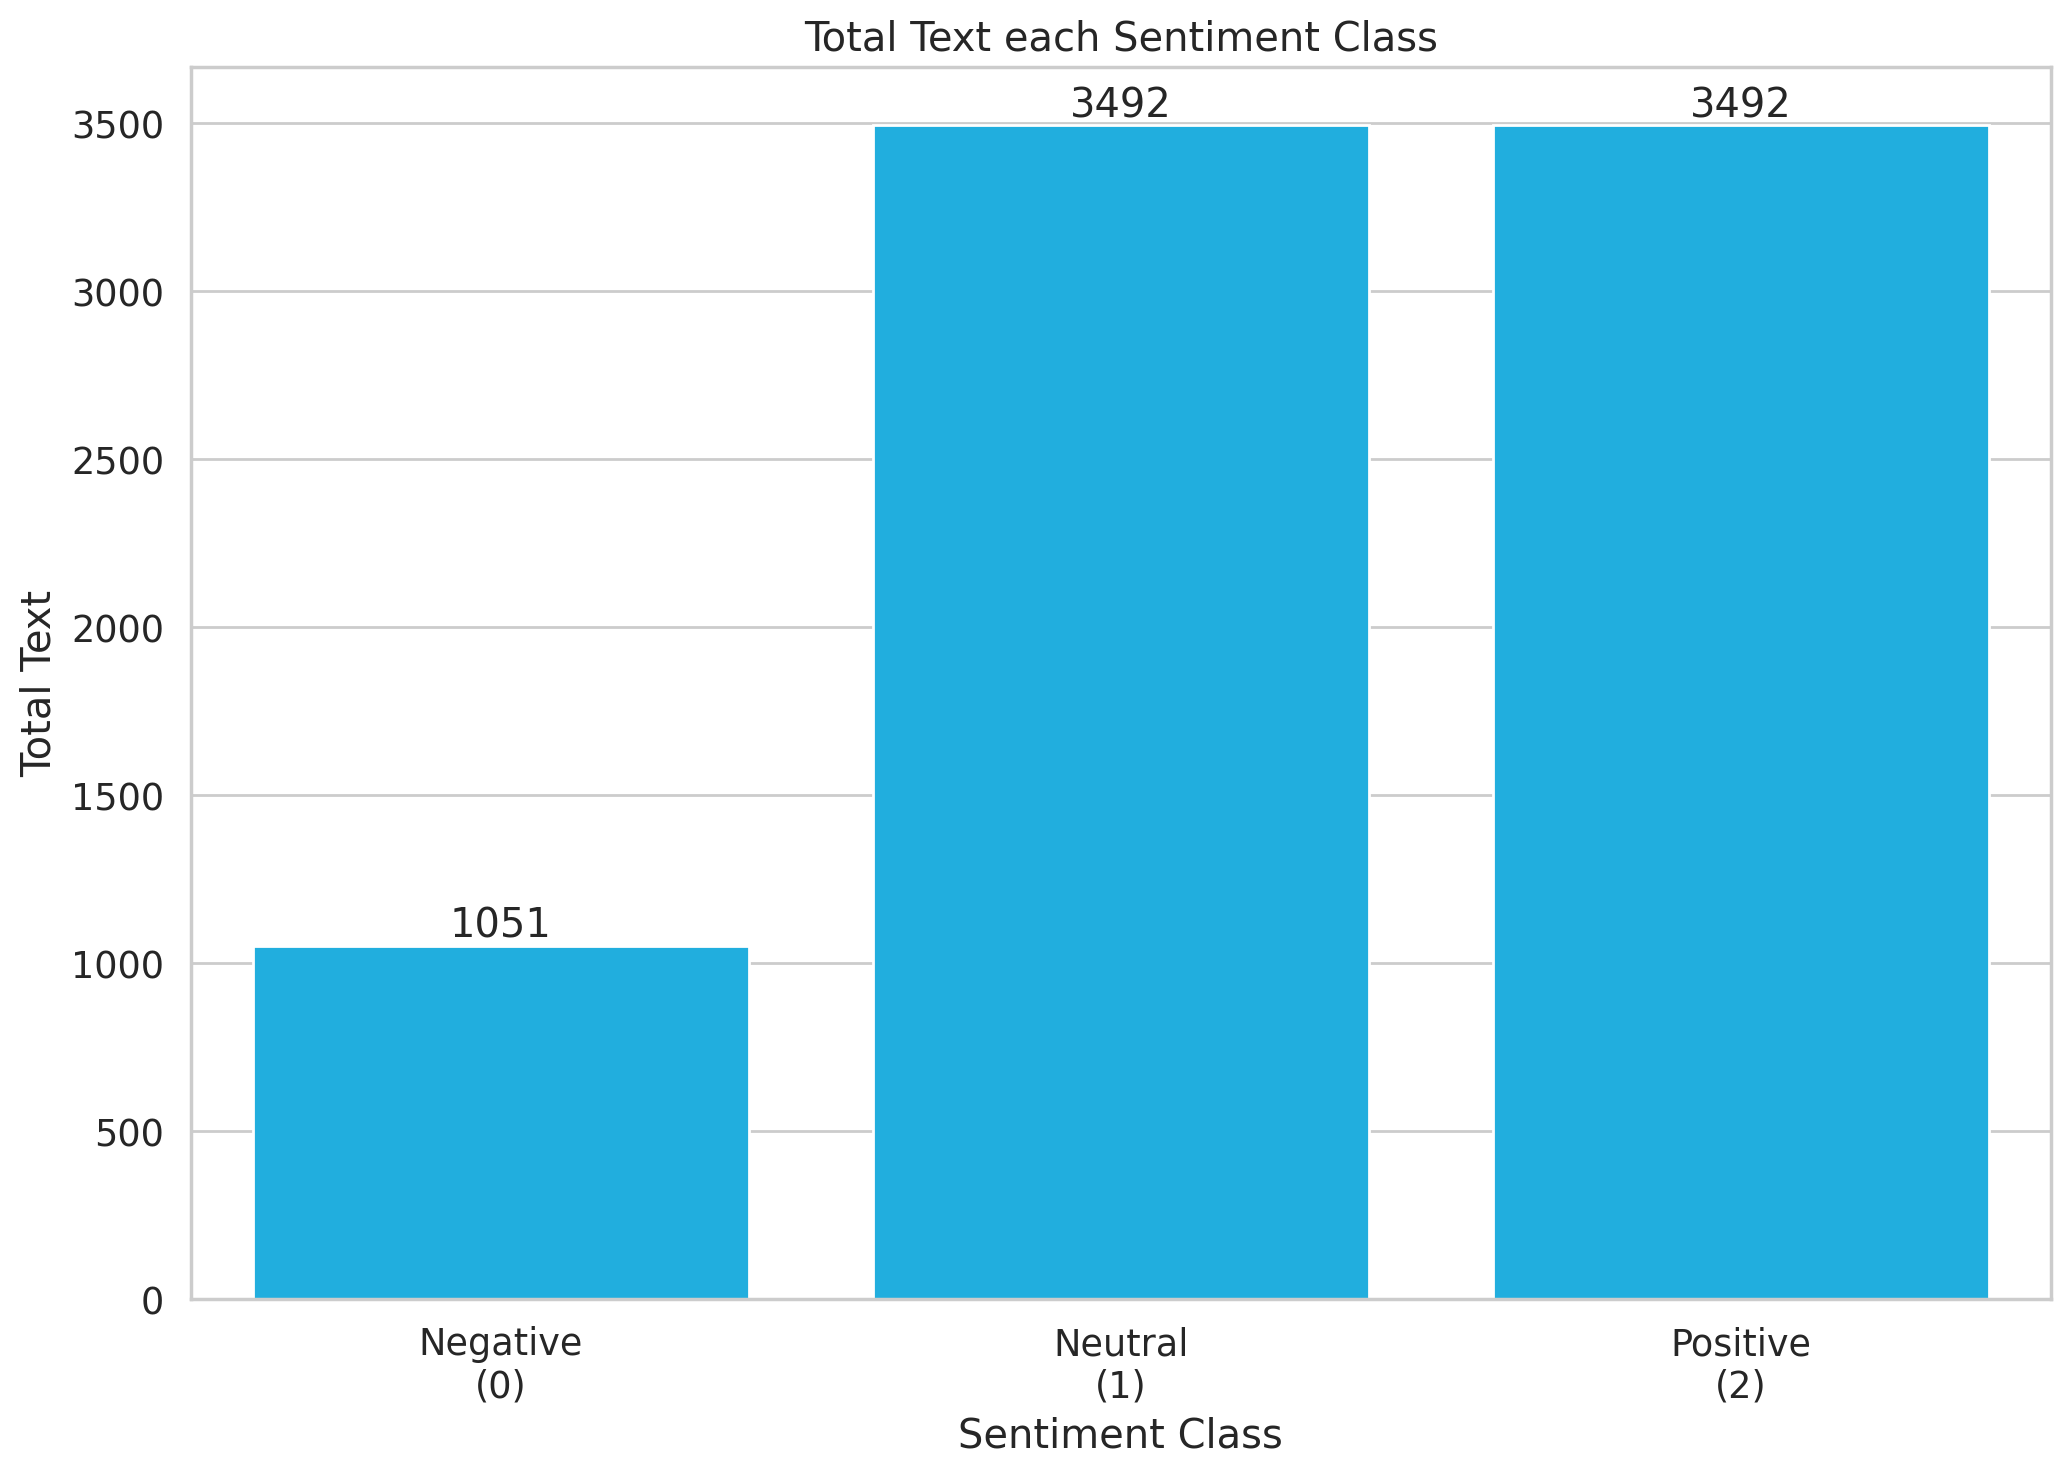

In [ ]:
## Draw Graph Penyebaran Class Sentiment
ax = sns.barplot(data=df_class_sentimen, x='class', y='total');
ax.set(xlabel='Sentiment Class',
       ylabel='Total Text',
       title='Total Text each Sentiment Class')
ax.bar_label(container=ax.containers[0], labels=df_class_sentimen.total)

# Save Image
plt.savefig('report/'+hashtag+'/total_penyebaran_kelas_sentiment.png')

## **Model Training**

#### **Load Model dan Tokenizier**

In [ ]:
## Declare Bert Model and Load Tokenizer + Bert Untrained.

from transformers import AutoTokenizer, AutoModel

# Ganti ini kalau mau ganti model basennya.
MODEL_NAME = 'indolem/indobert-base-uncased'

# Load Token sama Base Model.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

#### **Penyebaran Token Length pada Data**

In [ ]:
## Declare Variable Tampung
token_lens = []

## Count Length Token each Text Row.
for txt in df_data.text_final:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<ipython-input-18-d6322e56aeb7>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


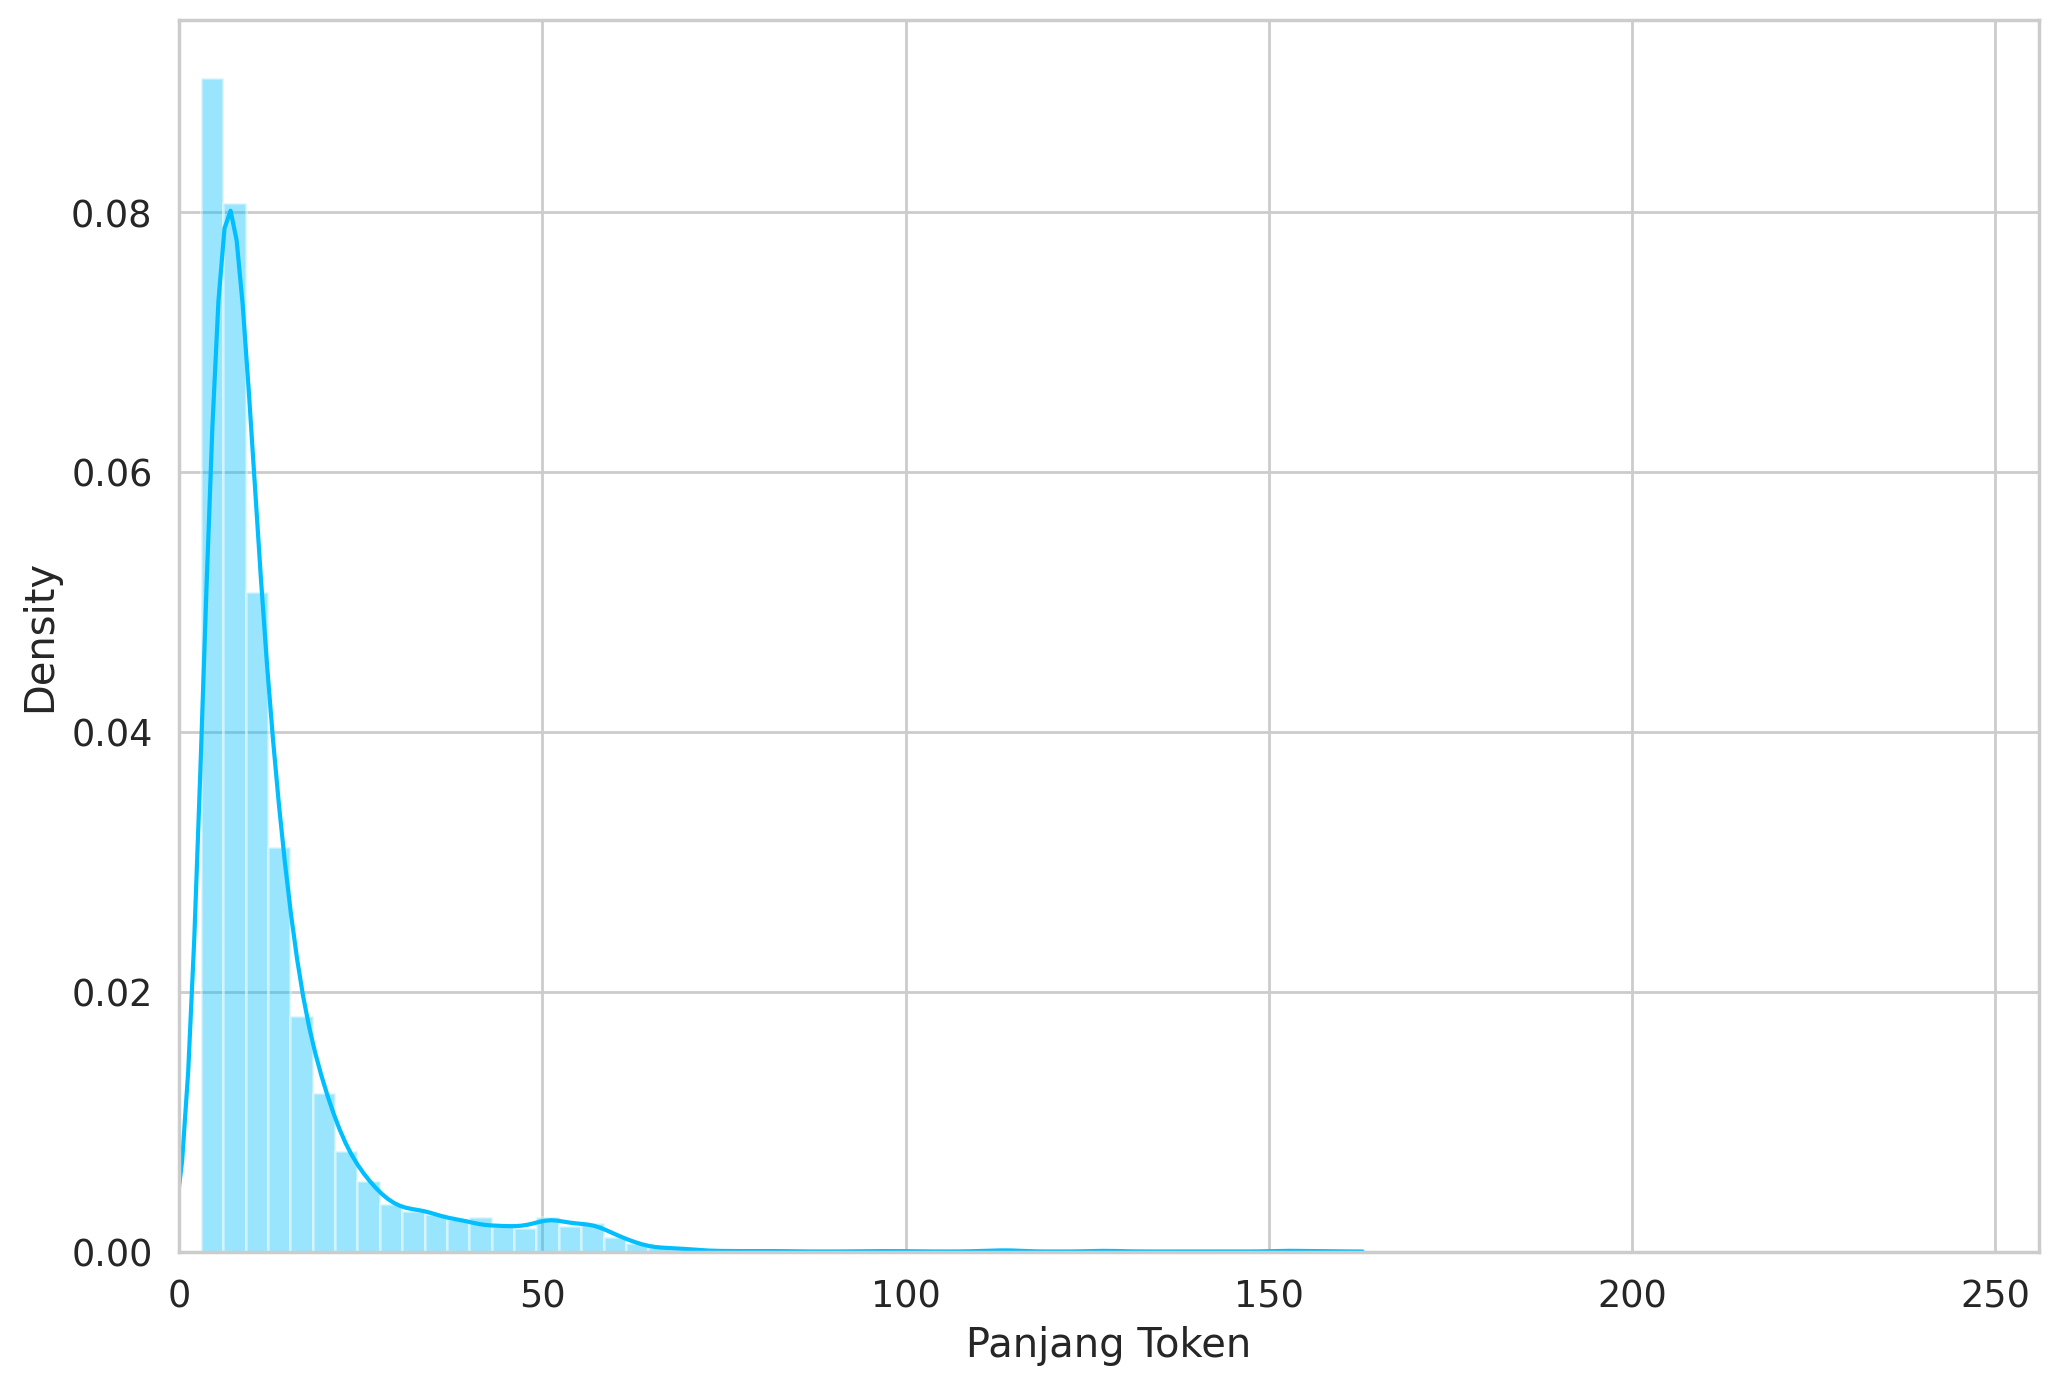

In [ ]:
## Plotting Graph
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Panjang Token');

# Save Image
plt.savefig('report/'+hashtag+'/penyebaran_panjang_token.png')

In [ ]:
## Set MAX_LEN token berdasarkan data diatas.
MAX_LEN = 175

## **Dataset Splitting 80% Training, 10% Testing, 10% Validation**


In [ ]:
## Splitting Data to 20% Testing and 80% Train
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=RANDOM_SEED)

## Splitting Data from 20% Testing to 10% Testing and 10% Training
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

## Save Dataframe Each Part
df_train.to_csv('data/training/'+hashtag+'/'+hashtag+'_train.csv', index=False)
df_test.to_csv('data/training/'+hashtag+'/'+hashtag+'_test.csv', index=False)
df_val.to_csv('data/training/'+hashtag+'/'+hashtag+'_val.csv', index=False)

print(df_train.shape, df_val.shape, df_test.shape)

(6428, 6) (803, 6) (804, 6)


## **Data Loader**



In [ ]:
## Declare Function for Encoding Tensor

class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len, id_tweet):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.id_tweet = id_tweet

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        ##
        id_tweet = str(self.id_tweet[item])
        ##
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long),
            'id_tweet': id_tweet
        }

In [ ]:
## Define Function Data Loader

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text_final.to_numpy(),
        targets=df.labelled.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
        id_tweet=df.id_tweet.to_numpy()
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
## Create train, test, val data loader and Set BATCH SIZE
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
## Examples Data after masuk ke Data Loader
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)
print(data['review_text'])
print(data['id_tweet'])

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets', 'id_tweet'])
torch.Size([32, 175])
torch.Size([32, 175])
torch.Size([32])
[' benar wey keren banget bujang', 'tumben aku group chat', 'auto langsung borong sih hadiah member stary kids', 'indomaret gsi', 'alfamart malang begini mana ', 'group suka collab sama susu suka fix habis bakal ngeborong buat stok ', 'suka minum ultra milk suka sama stray kids collab bareng nikmat mana woi', 'kota tidak cgv', ' cimory coklat kecil susah cari sedang vanilla sama vanilla tidak ukur liter', 'first of all thanku ultramym dontstopyourmove teman ayo ikutann pujie resa refikanayla alesan mau tonton itzy mau lihat cewek cewek cantik cara live tahun utama chaeryeong ryujin boys like cont', 'kira dikorea lho tadi tidak baca tulis bahasa indonesia jendela', 'happyeppin entar koleksi kotak', 'aowkaowkaowk ultramilkxitzy', 'mantap betul ', 'koperasi ', 'kalau beli felix tidak', 'aku anteng banget tunggu iklan satu ni', 'wey untung lewat fyp 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


##**Class Sentiment Classifier**

In [ ]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
## Declare Class Sentiment
class_names = ['Negative', 'Neutral', 'Positive']

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


##**Training Function**

In [ ]:
# Declare Epoch
EPOCHS = 10
LR = 2e-5

# Select Optimizer sama Declare nilai Learning Rate
optimizer = AdamW(model.parameters(), lr=LR, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

##**Training**

In [ ]:
# Check Path is Available if no Create Dir
if path.exists(root_file+'/model/'+hashtag) == False:
  os.makedirs(root_file+'/model/'+hashtag)
else :
  print("File Already Existed")

File Already Existed


In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc.detach().cpu().numpy())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.detach().cpu().numpy())
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'model/'+hashtag+'/bert_model_e'+str(EPOCHS)+'_lr'+str(LR)+'_bs'+str(BATCH_SIZE)+'.pkl')
        best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


##**Training History**


In [ ]:
plt.plot(history['train_loss'], label='train accuracy')
plt.plot(history['val_loss'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Save Image Wordcloud Generated
plt.savefig('report/'+hashtag+'/training_history_'+str(EPOCHS)+'_lr'+str(LR)+'_bs'+str(BATCH_SIZE)+'.png')

##**LOAD MODEL - Jika Diperlukan**


In [ ]:
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('model/'+hashtag+'/bert_model_e'+str(EPOCHS)+'_lr'+str(LR)+'_bs'+str(BATCH_SIZE)+'.pkl'))
# model = model.to(device)

##**Model Evaluation - Classification Report, Report Data, Confussion Matrixs, Fungsi Prediksi**

#### **Get Accuracy dan Declare Fungsi Prediction**

In [ ]:
## Print Testing Accuracy

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
## Declare Function Prediction

def get_predictions(model, data_loader):
    model = model.eval()

    ##
    id_text = []
    ##
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            ##
            id = d["id_tweet"]
            ##
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            ##
            id_text.extend(id)
            ##
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values, id_text

#### **Pengolahan Data untuk Recap Training Data**

In [ ]:
## DATA UNTUK TRAINING RECAP
y_review_texts, y_pred, y_pred_probs, y_test, id_texts = get_predictions(
    model,
    test_data_loader
)

def get_text(x):
  if x == 0:
    return "Negative"
  elif x == 1:
    return "Neutral"
  elif x == 2:
    return "Positive"

#id = id_texts.cpu().detach().numpy()
y_pred_numpy=y_pred.cpu().detach().numpy()
#print(y_pred_numpy)
y_test_numpy=y_test.cpu().detach().numpy()
#print(y_test_numpy)

df_train_false = pd.DataFrame(columns=['id_tweet', 'predicted', 'status'])

for x in range(0,len(y_pred_numpy)) :
  #if y_pred_numpy[x] != y_test_numpy[x]:
  df_train_false.loc[len(df_train_false.index)] = [id_texts[x], get_text(y_pred_numpy[x]), 'data_testing']
  #print(y_review_texts[x] + ' | Labelled : '+get_text(y_test_numpy[x])+' | Predicted : ' +get_text(y_pred_numpy[x]))

#df_data.set_index('id_tweet').join(df_train_false.set_index('id_tweet'))
df_train_false['id_tweet']=df_train_false['id_tweet'].astype(int)

df_train_false

In [ ]:
## DATA UNTUK VALIDATION RECAP dan Export Data ALL
y_review_texts, y_pred, y_pred_probs, y_test, id_texts = get_predictions(
    model,
    val_data_loader
)

def get_text(x):
  if x == 0:
    return "Negative"
  elif x == 1:
    return "Neutral"
  elif x == 2:
    return "Positive"

#id = id_texts.cpu().detach().numpy()
y_pred_numpy=y_pred.cpu().detach().numpy()
#print(y_pred_numpy)
y_test_numpy=y_test.cpu().detach().numpy()
#print(y_test_numpy)

df_validation = pd.DataFrame(columns=['id_tweet', 'predicted', 'status'])

for x in range(0,len(y_pred_numpy)) :
  #if y_pred_numpy[x] != y_test_numpy[x]:
  df_validation.loc[len(df_validation.index)] = [id_texts[x], get_text(y_pred_numpy[x]), 'data_validation']
  #print(y_review_texts[x] + ' | Labelled : '+get_text(y_test_numpy[x])+' | Predicted : ' +get_text(y_pred_numpy[x]))

#df_data.set_index('id_tweet').join(df_train_false.set_index('id_tweet'))
df_validation['id_tweet']=df_validation['id_tweet'].astype(int)

df_merge = pd.concat([df_train_false, df_validation], axis=0)
df_merge.reset_index(drop='true')
df_joined = df_data_asli.join(df_merge.set_index('id_tweet'), on='id_tweet')
df_joined.reset_index(drop="true")

In [ ]:
## Adding Data if polarity 4 and used for training
df_joined.loc[df_joined.labelling == 4, 'predicted'] = 'Not Predicted'
df_joined.loc[df_joined.labelling == 4, 'status'] = 'other'
df_joined.loc[df_joined.labelling == 4, 'labelled'] = 'Not Labelled'

df_joined.loc[df_joined.predicted.isnull() == True, 'predicted'] = 'Data Training'
df_joined.loc[df_joined.status.isnull() == True, 'status'] = 'data_training'
df_joined

In [ ]:
## Export Data Training, Testing, and Validation Result
df_joined.to_excel("report/"+hashtag+"/data_report_training.xlsx")

#### **Classification Report**

In [ ]:
## Do Testing Classification Report
y_review_texts, y_pred, y_pred_probs, y_test, id_texts = get_predictions(
    model,
    test_data_loader
)

In [ ]:
## Output Classification Report
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
## Save Classification Report
# Save Data Classification Report
class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
# Export Classification Report
df_cf = pd.DataFrame(class_report).transpose()
df_cf.to_csv('report/'+hashtag+'/classification_report_'+str(EPOCHS)+'_lr'+str(LR)+'_bs'+str(BATCH_SIZE)+'.csv', index=False)

#### **Confussion Matrix**

In [ ]:
## Declare Function CF
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

## Do CF
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Save Image
plt.savefig('report/'+hashtag+'/confusion_matrix_'+str(EPOCHS)+'_lr'+str(LR)+'_bs'+str(BATCH_SIZE)+'.png')

In [ ]:
df_cm

##**Test Predict**

In [ ]:
## Load Preprocess SLANG Module

# Load Dataframe
df_tmp_nasalsabila = pd.read_csv('data/slang/colloquial-indonesian-lexicon_nasalsabila.csv')
df_slang_fendiirfan = pd.read_csv('data/slang/colloquial-indonesian-lexicon_fendiirfan.csv')
df_slang_custom = pd.read_csv('data/slang/custom_dictonary_slang.csv')
df_slang_custom_exception = pd.read_csv('data/slang/custom_dictonary_slang_dont_swap.csv')

# Transform and Delete Duplicate Data from nasalsabila
df_slang_nasalsabila = df_tmp_nasalsabila[['slang', 'formal']]
df_slang_nasalsabila.drop_duplicates(inplace=True)

# Transform and Delete Duplicate Data from fendiirfan
df_slang_fendiirfan.dropna(inplace=True)
df_slang_fendiirfan.rename(columns={'kataAlay': 'slang', 'kataBaik': 'formal'}, inplace=True)
df_slang_fendiirfan.drop_duplicates(inplace=True)

# Transform and Delete Duplicate our own data.
df_slang_custom.drop_duplicates(inplace=True)
df_slang_custom_exception.drop_duplicates(inplace=True)

def remove_slang(text, df_tmp):
    # To Lowercase
    text = text.lower()

    # Pecah to array
    words = text.split(" ");

    # DF to Array
    arr_slang = df_tmp['slang'].to_numpy()
    arr_formal = df_tmp['formal'].to_numpy()
    do_not_change = df_slang_custom_exception['kata'].to_numpy()

    # Array New Text
    new_text = []

    for kata in words:
      if kata in arr_slang:
        if kata not in do_not_change:
          idx = np.where(arr_slang==kata)[0][0]
          kata = arr_formal[idx]

      new_text.append(kata)
      text_new = ' '.join(new_text)

    return text_new

In [ ]:
## Load Preprocess Stemming Modul
# Load and Download Library Sastrawi
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Indonesian Stopword by Sastrawi
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
## Load Preprocess Stopword Data

# Load Data Stopword from Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

# Load Data Stopword and Custom Word
stopword_satya = list(pd.read_csv('data/stopword/stopwords_satya.txt', header = None)[0])
custom_stopword = list(pd.read_csv('data/stopword/custom_stopword.txt', header = None)[0])
keep_custom_stopword = list(pd.read_csv('data/stopword/keep_custom_stopword.txt', header = None)[0])

def remove_stopwords(text):
  # Removal Stopword
  text_split = text.split(' ')

  temp_text_split = []
  for i in range(len(text_split)):
    ## Remove Stopword by Satwa : gak dipake dulu ini terlalu ngilangin konteks text
    #if (text_split[i] not in stopword_satya) and (text_split[i] not in custom_stopword):
    if (text_split[i] not in custom_stopword):
      ## Keep Beberapa Kata Valence of a text
      # https://datascience.stackexchange.com/questions/15765/nlp-why-is-not-a-stop-word#:~:text=Stop%20words%20are%20usually%20thought,idf%20analysis%20for%20document%20classification).
      if (text_split[i] in keep_custom_stopword) :
        temp_text_split.append(text_split[i])
      else :
        ## Stopword Removal from data by Sastrawi
        tmp = stopword.remove(text_split[i])
        temp_text_split.append(tmp)

  final_text = ' '.join(temp_text_split)

  # will replace single word
  final_text = re.sub(r"\b[a-zA-Z]\b","",final_text)

  # will replace space more than one
  final_text = re.sub("( {2,})"," ",final_text)

  return final_text

In [ ]:
def clean_text_predict(text) :

    ## TEXT TRANSFORM
    # Remove hashtag dan @
    ''.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    # Change "-" to space
    text = text.replace("-", " ")
    # Remove punctiation
    text  = "".join([char for char in text if char not in string.punctuation])
    # Remove angka
    text = re.sub('[0-9]+', '', text)
    # Remove website link
    text = re.sub(r'http\S+', '', text)
    # Remove new line
    text = re.sub("\n"," ",text)
    # Transform to lowercase
    text = text.lower()
    # Replace perulangan huruf pada kalimat "iyaaa" to "iya"
    text = re.sub(r'(\w)(\1{2,})', r"\1", text)
    # will replace single word
    text = re.sub(r"\b[a-zA-Z]\b","",text)
    # will replace space more than one
    text = re.sub('( {2,})',' ',text)

    ## SLANG
    text = remove_slang(text ,df_slang_nasalsabila)
    text = remove_slang(text ,df_slang_fendiirfan)
    text = remove_slang(text ,df_slang_custom)

    ## STEMMING
    text = stemmer.stem(text)

    ## STOPWORD
    text = remove_stopwords(text)

    ## TEXT TRANSFORM BUT AFTER
    # will replace single word
    text = re.sub(r"\b[a-zA-Z]\b","",text)

    return text

In [ ]:
review_text = "kemarin beli malah basi susunya"
txt_clean = clean_text_predict(review_text)

encoded_review = tokenizer.encode_plus(
    txt_clean,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text\t: {review_text}')
print(f'Clean text\t: {txt_clean}')
print(f'Sentiment\t: {class_names[prediction]}')